In [6]:
from functions.Segmentation_functions import *
from functions.CNN_Unet_functions import *


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os

from sklearn.model_selection import train_test_split

# Format Data and Preproces to make it CNN compatiable

## Preprocess for STC Deepseg_

In [11]:
#Load in Data for Testing (I.e., my data) ( IS ROTATED )

RARE_all = load_data(path= "C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz", resize= True, new_x= 200, new_y= 200)
RARE_all_slices = extract_slices(RARE_all, mask = False)

np.save("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_200_200",RARE_all_slices)


# Save as NIfTI file
nifti_img = nib.Nifti1Image(RARE_all_slices, np.eye(4))
nib.save(nifti_img, "C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_200_200.nii.gz")

In [8]:
#Load in Data for Testing (I.e., my data) ( NOT ROTATED)

RARE_all = load_data(path= "C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked.nii.gz", resize= True, new_x= 200, new_y= 200)
RARE_all_slices = extract_slices(RARE_all, mask= False)

np.save("C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked_200_200",RARE_all_slices)



## Preprocess for CNN

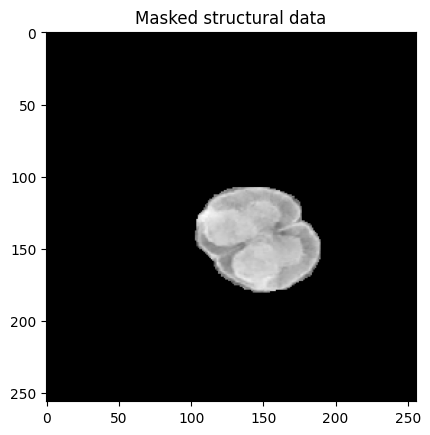

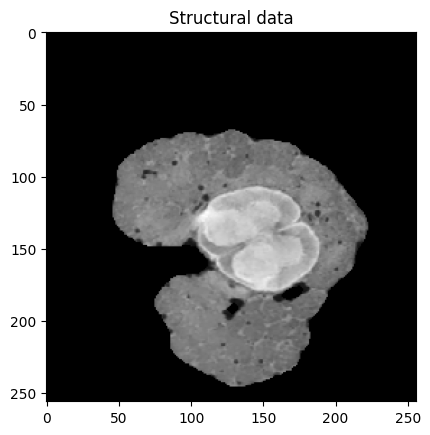

In [ ]:
#Masks
Simon_wm_mask = load_data("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/wm.nii.gz",resize = True)
Simon_gm_mask = load_data("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gm.nii.gz",resize = True)
Simon_wm_mask_200_200 = load_data("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/wm.nii.gz",resize = True, new_x = 200, new_y = 200)
Simon_gm_mask_200_200 = load_data("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gm.nii.gz",resize = True, new_x= 200, new_y = 200)



combined_mask = np.zeros_like(Simon_wm_mask)
combined_mask[Simon_wm_mask > 0] = 1 #label 1 = WM
combined_mask[Simon_gm_mask > 0] = 2 #label 2 = GM

#Structural data
Simon_struc_all = load_data("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/masked_gibbs_denoised_stitched_spinal_cord.nii.gz",resize = True)
Simon_struc_all_200_200 = load_data("C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/masked_gibbs_denoised_stitched_spinal_cord.nii.gz",resize = True, new_x = 200, new_y = 200)

####### Remove all voxels that aren't classified as 1 or 2. ###########
simon_struc_all_masked = mask_data(combined_mask, Simon_struc_all, dx = 5, dy = 5, dz = 1)


#### Plotting  ### 
plt.imshow(simon_struc_all_masked[:,:,100], cmap='gray')
#plt.imshow(combined_mask[:,:,100],alpha=0.1)
plt.title('Masked structural data')
plt.show()

plt.imshow(Simon_struc_all[:,:,100], cmap='gray')
plt.title('Structural data')
#plt.imshow(combined_mask[:,:,100], cmap='gray', alpha = 0.4)
plt.show()

(1919, 256, 256, 1)
(1919, 256, 256, 1)


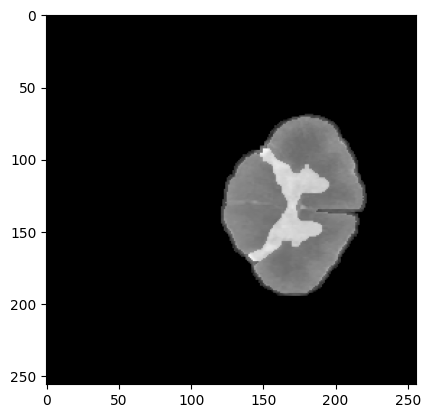

In [6]:
################## Turn the Data structure into something that is compatiable with CNN input and output: i.e., Slice and add channel dim #############
slices = extract_slices(simon_struc_all_masked)
slices_200_200 = extract_slices(Simon_struc_all_200_200)

slices_wmgm = extract_slices(combined_mask, mask = True)

slices_wm = extract_slices(Simon_wm_mask, mask = True)
slices_gm = extract_slices(Simon_gm_mask, mask = True)
slices_gm_200_200 = extract_slices(Simon_gm_mask_200_200, mask = True)
slices_wm_200_200 = extract_slices(Simon_wm_mask_200_200, mask = True)


### Save
#Struc
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/resized_masked_gibbs_denoised_stitched_spinal_cord_200_200",slices_200_200)
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/resized_masked_gibbs_denoised_stitched_spinal_cord",slices)
#Combined Masked
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_wmgm_mask",slices_wmgm)
#Wm
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_wm_mask",slices_wm)
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_wm_mask_200_200",slices_wm_200_200)
#GM
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_gm_mask",slices_gm)
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_gm_mask_200_200",slices_gm_200_200)

#Print shape
print(slices.shape)
print(slices_wmgm.shape)

#Plot Images
plt.imshow(slices[500][:,:,0], cmap='gray')
plt.imshow(slices_wmgm[500][:,:,0], cmap='gray', alpha=0.5)

## Train test Split for validation of SUBSET DATA

In [ ]:
#### Define the SUBSET!! range #######
z_indices = np.random.randint(0, slices.shape[0], size=200)

# Create subsets
slices_subset = slices[z_indices]
slices_wmgm_subset = slices_wmgm[z_indices]
slices_gm_subset = slices_gm[z_indices]
slices_wm_subset = slices_wm[z_indices]

# Print shapes to verify
print("slices_subset shape:", slices_subset.shape)
print("slices_wmgm_subset shape:", slices_wmgm_subset.shape)
print("slices_gm_subset shape:", slices_gm_subset.shape)
print("slices_wm_subset shape:", slices_wm_subset.shape)


####### Split into train and test sets ######
X_train_gm_sub, X_test_gm_sub, y_train_gm_sub, y_test_gm_sub = train_test_split(slices_subset, slices_gm_subset, test_size=0.2, random_state=42)

class_weights_gm_sub = compute_class_weight('balanced', classes=np.unique(y_train_gm_sub),  y = y_train_gm_sub.flatten())
class_weight_dict_gm_sub = {i: class_weights_gm_sub[i] for i in range(len(class_weights_gm_sub))}

unique, counts = np.unique(y_train_gm_sub, return_counts=True)
print(dict(zip(unique, counts)))

slices_subset shape: (200, 256, 256, 1)
slices_wmgm_subset shape: (200, 256, 256, 1)
slices_gm_subset shape: (200, 256, 256, 1)
slices_wm_subset shape: (200, 256, 256, 1)
{np.float64(0.0): np.int64(10170347), np.float64(1.0): np.int64(315413)}


## Train test Split for validation of full DATA

In [5]:
#### Train and Test split for Multiclass Classification ############
X_train, X_test, y_train, y_test = train_test_split(slices, slices_wmgm, test_size=0.2, random_state=42)
print(y_train.shape)

#One hot encoding of Y
y_train_cat = keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=3)

sample_weights = sample_weight(y_train= y_train)


######### Train and Test split for Binary Classification ############# 

####### Split into train and test sets ######
X_train_gm, X_test_gm, y_train_gm, y_test_gm = train_test_split(slices, slices_gm, test_size=0.2, random_state=42)

class_weights_gm = compute_class_weight('balanced', classes=np.unique(y_train_gm),  y = y_train_gm.flatten())
class_weight_dict_gm = {i: class_weights_gm[i] for i in range(len(class_weights_gm))}

unique, counts = np.unique(y_train_gm, return_counts=True)
print(dict(zip(unique, counts)))


###### Split into train and test sets #####
X_train_wm, X_test_wm, y_train_wm, y_test_wm = train_test_split(slices, slices_wm, test_size=0.2, random_state=42)

class_weights_wm = compute_class_weight('balanced', classes=np.unique(y_train_wm),  y = y_train_wm.flatten())
class_weight_dict_wm = {i: class_weights_wm[i] for i in range(len(class_weights_wm))}

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


(1535, 256, 256, 1)
{np.float64(0.0): np.int64(86159378), np.float64(1.0): np.int64(11524310), np.float64(2.0): np.int64(2914072)}
shape of sample weights: (1535, 256, 256, 1)
{np.float64(0.0): np.int64(97683688), np.float64(1.0): np.int64(2914072)}
{np.float64(0.0): np.int64(86159378), np.float64(1.0): np.int64(11524310), np.float64(2.0): np.int64(2914072)}


In [ ]:

unique, counts = np.unique(y_train_cat[:,:,:,0], return_counts=True)
print(dict(zip(unique, counts)))


unique, counts = np.unique(y_train_cat[:,:,:,1], return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train_cat[:,:,:,2], return_counts=True)
print(dict(zip(unique, counts)))

# Build U-Net Multi-class Classification.

Explanation of Batch Size and Epochs: 
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [12]:
# Multi class classification:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#Build the arcihtecture of the model:
unet_model = build_unet_model()
#Compile Model:
unet_model.compile(optimizer="adam", loss= masked_categorical_crossentropy, metrics= METRICS)


In [ ]:
#Train the model:
history = unet_model.fit(X_train, y_train_cat, 
                         batch_size=BATCH_SIZE, 
                         epochs=10, 
                         validation_data = (X_test, y_test_cat),
                         sample_weight = sample_weights)

unet_model.save('unet_model_sample_weights_masked_loss.keras')

#Save weights
initial_weights = os.path.join("temp_weights", f'initial_sample.weights.h5')
unet_model.save_weights(initial_weights)


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()





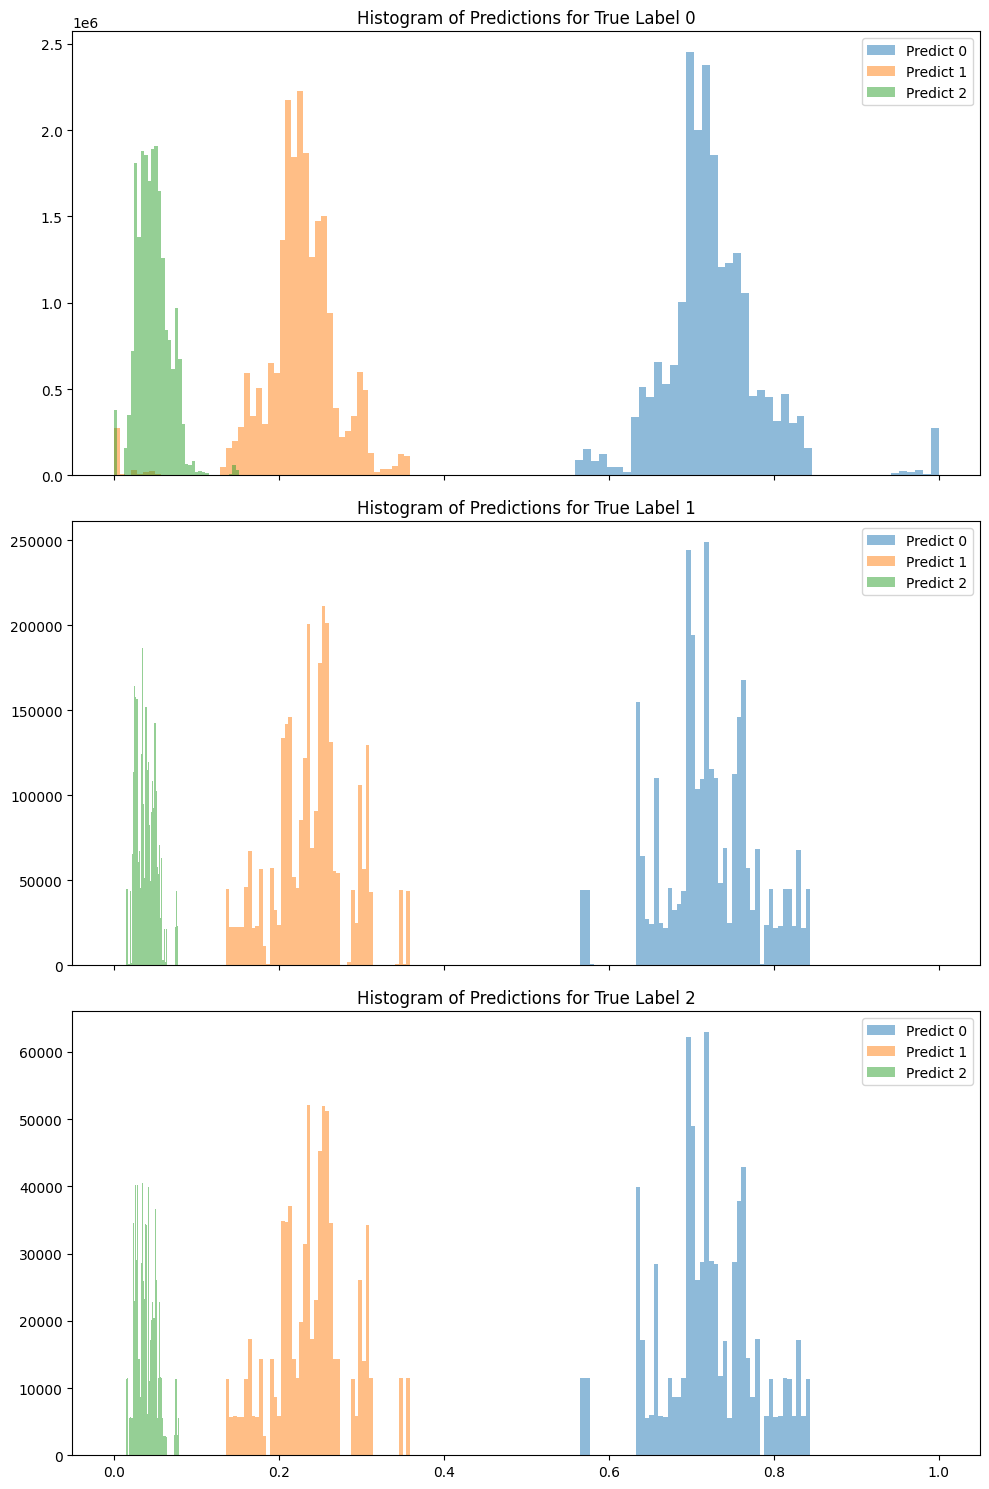

In [ ]:
#Predictions
predictions = unet_model.predict(X_test)
prediction_labels = np.argmax(predictions, axis=-1)


# Extract the prediction values where the true label is 0
true_label_0_indices = np.where(y_test_cat[..., 0] == 1)
prediction_values_true_label_0 = predictions[true_label_0_indices]

# Extract the prediction values where the true label is 1
true_label_1_indices = np.where(y_test_cat[..., 1] == 1)
prediction_values_true_label_1 = predictions[true_label_1_indices]

# Extract the prediction values where the true label is 2
true_label_2_indices = np.where(y_test_cat[..., 2] == 1)
prediction_values_true_label_2 = predictions[true_label_2_indices]

# Plot histograms of prediction values for each true label
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
axs[0].hist(prediction_values_true_label_0[:,0], bins=50, label="Predict 0", alpha=0.5)
axs[0].hist(prediction_values_true_label_0[:,1], bins=50, label="Predict 1", alpha=0.5)
axs[0].hist(prediction_values_true_label_0[:,2], bins=50, label="Predict 2", alpha=0.5)
axs[0].set_title('Histogram of Predictions for True Label 0')
axs[0].legend()

axs[1].hist(prediction_values_true_label_1[:,0], bins=50, label="Predict 0", alpha=0.5)
axs[1].hist(prediction_values_true_label_1[:,1], bins=50, label="Predict 1", alpha=0.5)
axs[1].hist(prediction_values_true_label_1[:,2], bins=50, label="Predict 2", alpha=0.5)
axs[1].set_title('Histogram of Predictions for True Label 1')
axs[1].legend()

axs[2].hist(prediction_values_true_label_2[:,0], bins=50, label="Predict 0", alpha=0.5)
axs[2].hist(prediction_values_true_label_2[:,1], bins=50, label="Predict 1", alpha=0.5)
axs[2].hist(prediction_values_true_label_2[:,2], bins=50, label="Predict 2", alpha=0.5)
axs[2].set_title('Histogram of Predictions for True Label 2')
axs[2].legend()

plt.tight_layout()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step


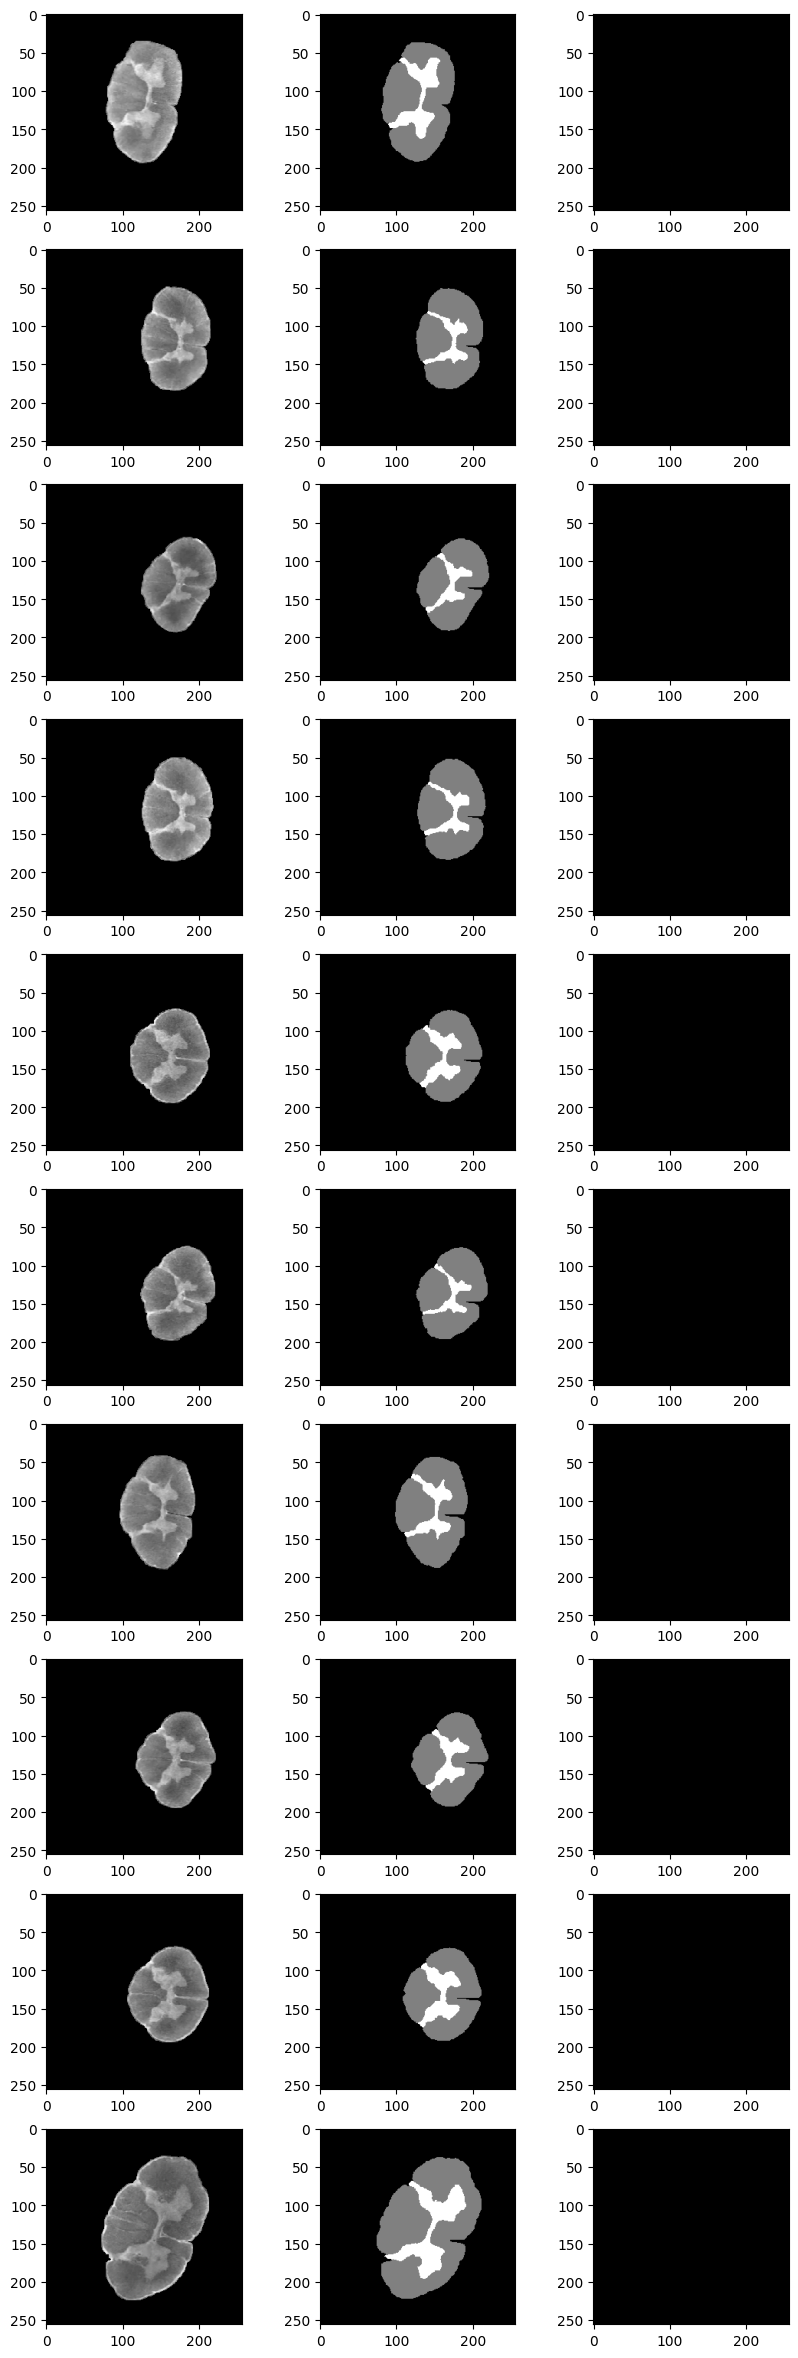

In [ ]:
# Plot the first 10 test images, the predicted labels and the true labels.
fig, axes = plt.subplots(10, 3, figsize=(10, 30))
for i in range(10):
    axes[i, 0].imshow(X_test[i, :, :, 0], cmap='gray')
    axes[i, 1].imshow(y_test[i, :, :, 0], cmap='gray')
    axes[i, 2].imshow(prediction_labels[i], cmap='gray')


# Binary U-Net

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#Build the arcihtecture of the model:
unet_model_binary = build_unet_model_binary()
#Compile Model:
unet_model_binary.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)

#Train the model:
historybin = unet_model_binary.fit(X_train_gm, y_train_gm, batch_size=BATCH_SIZE, epochs= 2, validation_data = (X_test_gm, y_test_gm), class_weight = class_weight_dict_gm)
unet_model_binary.save('unet_model_gm_bin.keras')

# Check if the model was trained with class weights
if 'class_weight' in historybin.params:
    print("The model was trained with class weights.")
else:
    print("The model was not trained with class weights.")
historybin.params

#Plot
plot_history(historybin = historybin)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2077s 86s/step - Brier score: 0.1988 - accuracy: 0.9361 - auc: 0.4460 - cross entropy: 0.6203 - fn: 1557392.8750 - fp: 973973.9375 - loss: 0.6203 - prc: 0.0277 - precision: 0.0169 - recall: 0.0209 - tn: 51804820.0000 - tp: 16751.0000 - val_Brier score: 0.0293 - val_accuracy: 0.9708 - val_auc: 0.4698 - val_cross entropy: 0.1891 - val_fn: 734280.0000 - val_fp: 0.0000e+00 - val_loss: 0.1891 - val_prc: 0.0255 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 24431544.0000 - val_tp: 0.0000e+00
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1632s 68s/step - Brier score: 0.0287 - accuracy: 0.9711 - auc: 0.4780 - cross entropy: 0.1511 - fn: 1570388.5000 - fp: 0.0000e+00 - loss: 0.1511 - prc: 0.0261 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 52782548.0000 - tp: 0.0000e+00 - val_Brier score: 0.0286 - val_accuracy: 0.9708 - val_auc: 0.4752 - val_cross entropy: 0.1342 - val_fn: 734280.0000 - val_fp: 0.0000e+00 - val_loss: 0.1342 - val_prc: 0.0261 - v

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 203s 59s/step - Brier score: 0.2667 - accuracy: 0.3310 - auc: 0.5604 - cross entropy: 0.7279 - fn: 75863.0000 - fp: 7517452.0000 - loss: 0.9439 - prc: 0.0620 - precision: 0.0323 - recall: 0.7477 - tn: 3168978.7500 - tp: 247754.2500 - val_Brier score: 0.9710 - val_accuracy: 0.0273 - val_auc: 0.5093 - val_cross entropy: 40.6811 - val_fn: 0.0000e+00 - val_fp: 2549769.0000 - val_loss: 0.9467 - val_prc: 0.0278 - val_precision: 0.0273 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 71671.0000
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 174s 53s/step - Brier score: 0.9700 - accuracy: 0.0298 - auc: 0.5012 - cross entropy: 3047.6130 - fn: 0.0000e+00 - fp: 8137070.0000 - loss: 0.9421 - prc: 0.0299 - precision: 0.0298 - recall: 1.0000 - tn: 0.0000e+00 - tp: 251537.7500 - val_Brier score: 0.9727 - val_accuracy: 0.0273 - val_auc: 0.5000 - val_cross entropy: 93964.5781 - val_fn: 0.0000e+00 - val_fp: 2549769.0000 - val_loss: 0.9468 - val_prc: 0.0273 - val_precision: 0.

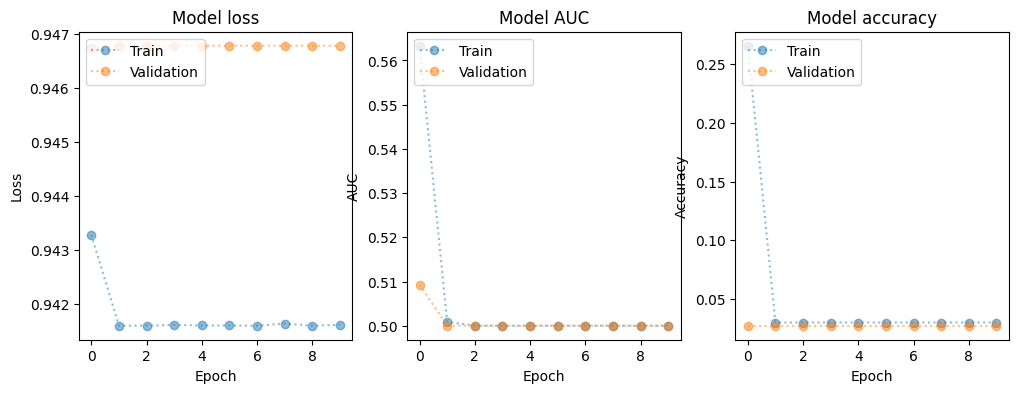

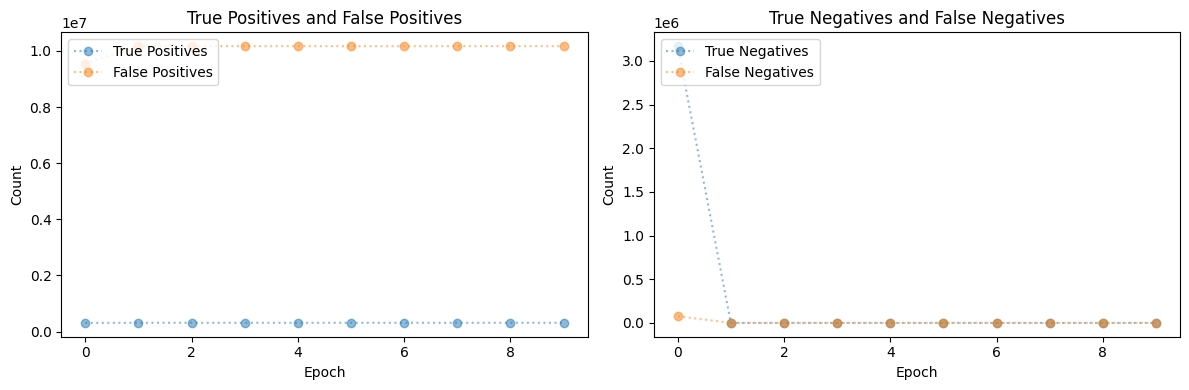

In [28]:
### Training with Subset of Data
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#Build the arcihtecture of the model:
unet_model_binary_sub = build_unet_model_binary()
#Compile Model:
unet_model_binary_sub.compile(optimizer="adam", loss = dice_loss, metrics=METRICS)

#Train the model:
historybin = unet_model_binary_sub.fit(X_train_gm_sub, y_train_gm_sub, batch_size=BATCH_SIZE, epochs= 10, validation_data = (X_test_gm_sub, y_test_gm_sub)) # , class_weight = class_weight_dict_gm_sub
unet_model_binary_sub.save('unet_model_gm_bin_masked_loss.keras')

# Check if the model was trained with class weights
if 'class_weight' in historybin.params:
    print("The model was trained with class weights.")
else:
    print("The model was not trained with class weights.")
historybin.params

#Plot
plot_history(historybin = historybin)

In [ ]:
# Predict class labels
predictions = unet_model_binary_sub.predict(X_test_gm_sub)

#Convert probabilities to binary
predictions_gm_bin = np.copy(predictions)
predictions_gm_bin[predictions_gm_bin > 0.5] = 1
predictions_gm_bin[predictions_gm_bin <= 0.5] = 0

#Plot Prediction Probabiliy Distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].hist(predictions[:,:,:,0].flatten(), bins=50)
axs[0].set_title('Probability Histogram of Predictions')
axs[1].hist(predictions_gm_bin[:,:,:,0].flatten(), bins=50)
axs[1].set_title('Binary Histogram of Predictions')
plt.show()

#plot Predictions 
z = 20
plt.imshow(X_test_gm_sub[z,:,:,0], cmap = "gray")
plt.imshow(predictions_gm_bin[z,:,:], alpha=0.5)
plt.show()
plt.imshow(X_test_gm_sub[z,:,:,0], cmap = "gray")
plt.imshow(y_test_gm_sub[z,:,:], alpha=0.5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


# **Compile and Train U-net**

In [8]:
# Predict class labels
predictions = unet_model.predict(X_test)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=-1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step


N label(1) = 4741310 N label(2) = 0  N label(0) = 20424514


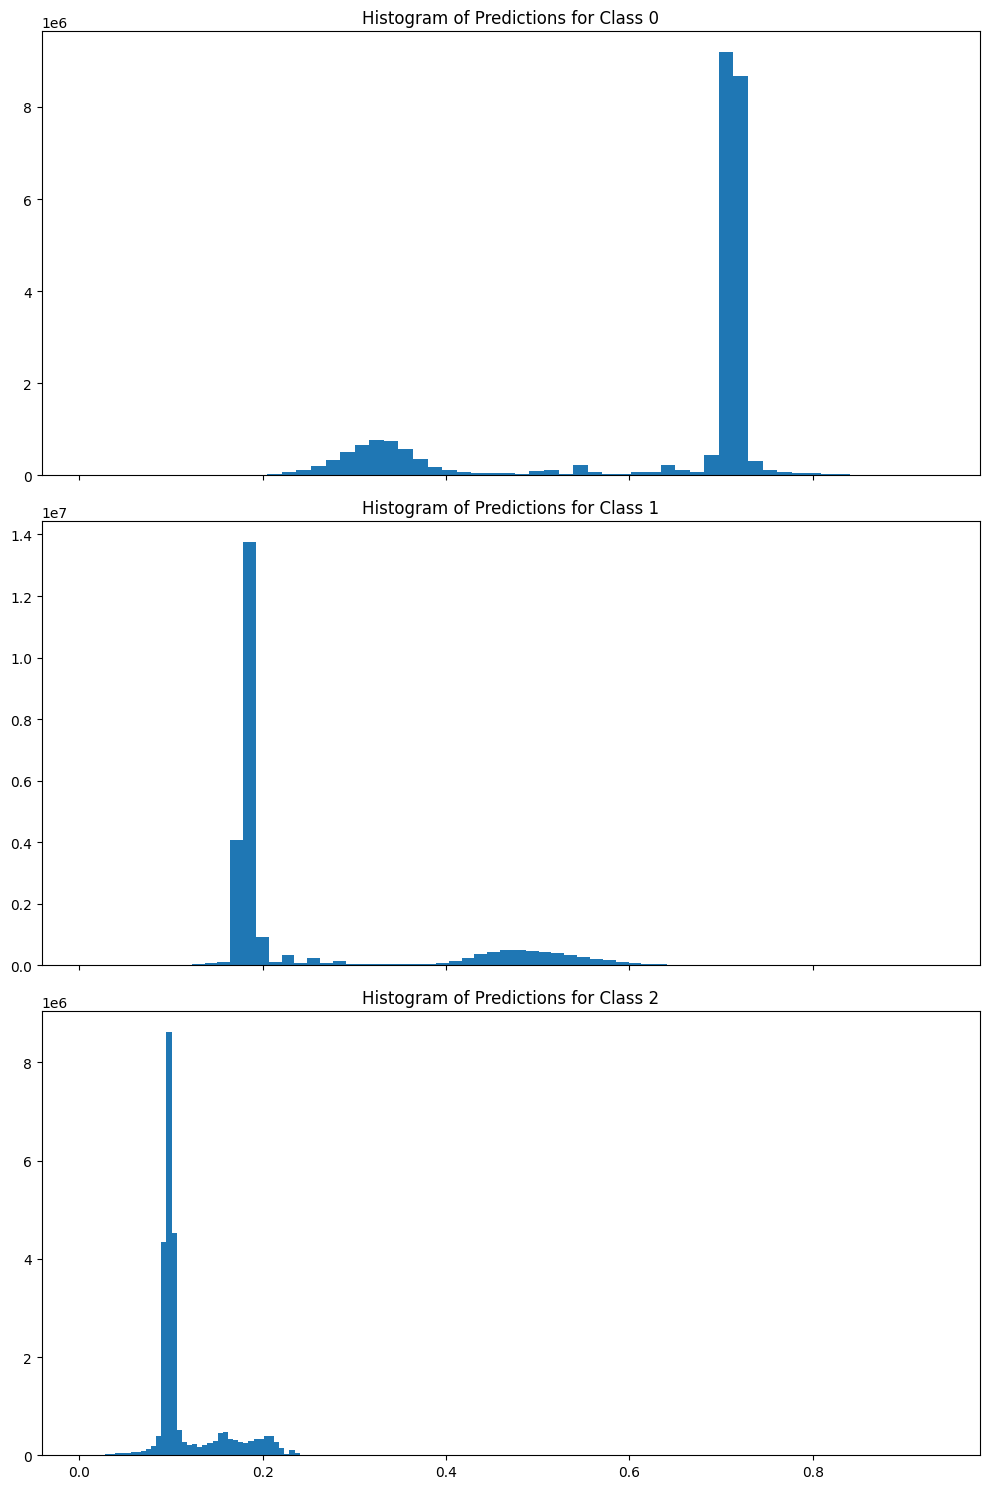

In [9]:

fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
axs[0].hist(predictions[:,:,:,0].flatten(), bins=50)
axs[0].set_title('Histogram of Predictions for Class 0')
axs[1].hist(predictions[:,:,:,1].flatten(), bins=50)
axs[1].set_title('Histogram of Predictions for Class 1')
axs[2].hist(predictions[:,:,:,2].flatten(), bins=50)
axs[2].set_title('Histogram of Predictions for Class 2')
plt.tight_layout()

print(f"N label(1) = {np.sum(predicted_labels == 1)}", f"N label(2) = {np.sum(predicted_labels == 2)}", f" N label(0) = {np.sum(predicted_labels == 0)}")

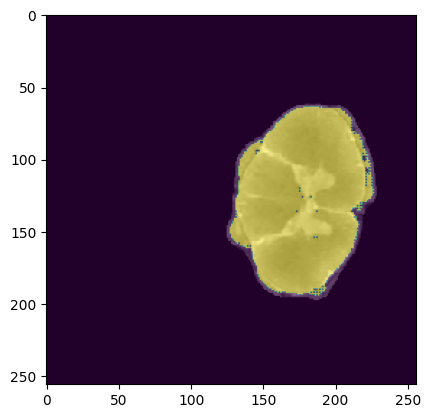

In [15]:
plt.imshow(X_test[120,:,:,0], cmap = "gray")
plt.imshow(predicted_labels[120,:,:], alpha=0.5)

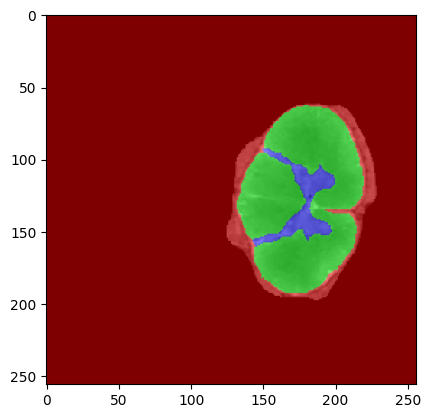

In [16]:
plt.imshow(X_test[120,:,:,0], cmap = "gray")
plt.imshow(y_test[120,:,:], alpha=0.5)

In [ ]:
# Load the saved model
loaded_unet_model = tf.keras.models.load_model('unet_model.keras')

c:\Users\Bruger\anaconda3\envs\Tensorflow\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [73]:
#Random Forrest:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Flatten images into 1D arrays
X = slices.flatten().reshape(-1, 1)  # Intensity as feature
y = slices_wmgm.flatten()  # Segmentation labels

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Evaluate accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))


MemoryError: Unable to allocate 768. MiB for an array with shape (100610867,) and data type int64

In [ ]:

# Reshape and visualize segmentation result
segmented_image = rf.predict(X).reshape(resized_Simon_struc_all.shape)